**This notebook teaches how to:**  
set up frames, create fields, create integration variables, set up derivatives, set up integration instructions, run simulations, write and read data, resume from dump files, and deactivate the progess bar.

In addition to the `simframe` requirements, the following packages are needed for this notebook: `matplotlib`, `scipy`.

# 1. Simple Integration

In this tutorial we want to solve the most simple differential equation

$\frac{\mathrm{d}Y}{\mathrm{d}x} = b\ Y$

with the initial condition

$Y \left( 0 \right) = A$.

This problem has the solution

$Y \left( x \right) = A\ e^{bx}$.

We set up some parameters that allow us to easily change the problem and rerun the simulation.

In [1]:
A  = 10.  # Initial value of Y
b  = -1.  # decay factor
dx =  0.1 # Stepsize

## Setting up frames

Frame objects are the core functionality of `simframe`. They contain everything you need to run a simulation, from variable to parameters to integration schemes.

In [2]:
from simframe import Frame

Here we set up a `Frame` object called `sim` and give it a meaningful description of our problem.

In [3]:
sim = Frame(description="Simple Integration")

Right now the frame is empty. It contains attributes for integration and writing of data, that we need to specify later.

In [4]:
sim

Frame (Simple Integration)
--------------------------
    Integrator   : not specified
    Writer       : not specified

## Creating fields

We can now fill the empty frame with our problem. First, we create a field for our variable `Y` and initialize it with its initial value `A`. Upon initialization field need to have the correct shape and data type already. This cannot be changed later.

In [5]:
sim.addfield("Y", A)

The frame object has now the field `Y`.

In [6]:
sim

Frame (Simple Integration)
--------------------------
    Y            : Field
  -----
    Integrator   : not specified
    Writer       : not specified

You can do all kinds of operations with `Y` just as with `numpy.ndarray`.

In [7]:
sim.Y + 3

13.0

In [8]:
import numpy as np

In [9]:
np.exp(sim.Y)

22026.465794806718

## Setting up derivatives

To solve for `Y` we have to specify a derivative of the field that can be used by the integrator. The function for the derivative of any variable needs the frame object, the integration variable, and the variable itself as positional arguments and needs to return the value of the derivative.

`derivative(frame, x, Y)`

In our case here the derivative is very simple but more complex equations could also use different fields by adressing them via the `frame` object.

In [10]:
def dYdx(frame, x, Y):
    return b*Y

Now we have to assign this function to the differentiator of our variable `Y`.

In [11]:
sim.Y.differentiator = dYdx

The derivative can be called with `.derivative(x, Y)`. If you don't give `x` or `Y`, then `simframe` assumes the current values, which does not work at this moment, because we have not set `x`, yet.

In [12]:
sim.Y.derivative(0., A)

-10.0

## Creating integration variables

Every frame objects needs at least one integration variable that controls the workflow and is advancing the simulation in space or time for example. In our case this is `x`. Integration variables can be added to the frame object just as fields.

In [13]:
sim.addintegrationvariable("x", 0.)

The frame objects has now the integration variable `x`.

In [14]:
sim

Frame (Simple Integration)
--------------------------
    x            : IntVar, Integration variable
    Y            : Field
  -----
    Integrator   : not specified
    Writer       : not specified

The integration variable is used to advance the simulation in `x` in our case and needs to know about the stesize. We therefore have to create a function that returns `dx`. The only argument of this function has to be the frame object and needs to return the step size.

In our simple case we just want to return a constant step size that we defined earlier.

In [15]:
def f_dx(frame):
    return dx

We now have to tell the updater of the itnegration variable to use this function.

In [16]:
sim.x.updater = f_dx

In addition to that, the integration variable needs to know about snapshots, i.e. points in space or time, when data should be written. Even you don't want to write data, you need to give at least one fineal value, because `simframe` needs to know when to stop the calculation. The snapshots have to be either a list or an array with the desired snapshots in increasing order.

In [17]:
sim.x.snapshots = np.linspace(1., 10., 10)

Compared to regular fields, integration variables have additional functionality. For example we can get the current step size, the maximum possible step size until the next snapshot is written, and the value of the integration variable at the next snapshot.

In [18]:
sim.x.stepsize

0.1

In [19]:
sim.x.maxstepsize

1.0

In [20]:
sim.x.nextsnapshot

1.0

The previously taken stepsize can be accessed with the following attribute, which is set to $0$ by default upon initialization.

In [21]:
sim.x.prevstepsize

0.0

## Setting up the integrator

So far we have set up our variables. But we also need to set up an integrator that is performing the actual integration. In our case we want to use a simple explicit Euler 1st-order scheme. The integrator needs the integration variable as positional argument during initialization. We could therefore for example set up different integrators with different integration variables and exchange them midway.

In [22]:
from simframe import Integrator

In [23]:
sim.integrator = Integrator(sim.x, description="Euler 1st-order")

The frame object has now an integrator set.

In [24]:
sim

Frame (Simple Integration)
--------------------------
    x            : IntVar, Integration variable
    Y            : Field
  -----
    Integrator   : Integrator (Euler 1st-order)
    Writer       : not specified

The integrator is basically a container for integration instructions. We therefore have to give tell it which integration instructions it should perform. Instructions have to be a list of `Instruction` objects, which need an integration scheme and a field to be integrated as positional arguments.

In [25]:
from simframe import Instruction
from simframe import schemes

In [26]:
sim.integrator.instructions = [Instruction(schemes.expl_1_euler, sim.Y)]

## Setting up writers

The simulation is now basically ready to go. But in this example we also want to write data files. We therefore have to specify a writer to our frame object. In this case we want to write data files in the `hdf5` format.

In [27]:
from simframe import writers

In [28]:
sim.writer = writers.hdf5writer()

The `hdf5writer` come with a few pre-defined options.

In [29]:
sim.writer

Writer (HDF5 file format using h5py)
------------------------------------
    Data directory : data
    File names     : data/data0000.hdf5
    Overwrite      : False
    Dumping        : True
    Options        : {'com': 'lzf', 'comopts': None}
    Verbosity      : 1

First, we want to change the data directory to which the files are written. If the data directory does not exist, `simframe` will create it.

In [30]:
sim.writer.datadir = "1_data"

And second, we want the writer to overwrite existing files. In that way we can easily restart the notebook with different parameters. Usually a writer will not allow you to overwrite existing files to protect your data.

In [31]:
sim.writer.overwrite = True

In [32]:
sim.writer

Writer (HDF5 file format using h5py)
------------------------------------
    Data directory : 1_data
    File names     : 1_data/data0000.hdf5
    Overwrite      : True
    Dumping        : True
    Options        : {'com': 'lzf', 'comopts': None}
    Verbosity      : 1

By default the writer is writing dump files at every snapshot. In contrast to data files, which only contain the data, a dump file contains the entire frame object from which the simulation can be restarted if anything went wrong. Since these files can be large for bigger projects, it always overwrites the existing dump file.

## Running simulations

The frame objects is now completely set up and we are ready to go.

In [33]:
sim.run()

Writing file 1_data/data0000.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0001.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0002.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0003.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0004.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0005.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0006.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0007.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0008.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0009.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0010.hdf5
Writing dump file 1_data/frame.dmp
Execution time: 0:00:00


## Reading data

Every writer should come with a reader that contains instructions for reading the data files the writer has written. It is possible to read a single output file.

In [34]:
data3 = sim.writer.read.output(3)

This returns the namespace containing the data of the chosen output file.

In [35]:
data3

namespace(Y=array([0.42391158]),
          description=b'Simple Integration',
          x=array([3.]))

You can check for existing files in the data directory.

In [36]:
sim.writer.read.listfiles()

['1_data/data0000.hdf5',
 '1_data/data0001.hdf5',
 '1_data/data0002.hdf5',
 '1_data/data0003.hdf5',
 '1_data/data0004.hdf5',
 '1_data/data0005.hdf5',
 '1_data/data0006.hdf5',
 '1_data/data0007.hdf5',
 '1_data/data0008.hdf5',
 '1_data/data0009.hdf5',
 '1_data/data0010.hdf5']

Or you can read the complete data that is in the data directory.

In [37]:
data = sim.writer.read.all()

The fields can be easily adressed just as with the frame object.

In [38]:
data.Y

array([1.00000000e+01, 3.48678440e+00, 1.21576655e+00, 4.23911583e-01,
       1.47808829e-01, 5.15377521e-02, 1.79701030e-02, 6.26578748e-03,
       2.18474501e-03, 7.61773480e-04, 2.65613989e-04])

Instead of reading the full data set or a single snapshots, it is also possible to read a single field from all snapshots.

In [39]:
seq = sim.writer.read.sequence("x")

In [40]:
seq

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

We now want to fit a function to the data to see, if we can reconstruct the initial parameters.

In [41]:
def fit(x, A, b):
    return A*np.exp(b*x)

In [42]:
from scipy.optimize import curve_fit

In [43]:
popt, pcov = curve_fit(fit, data.x, data.Y)

In [44]:
from IPython.display import Markdown as md
md("| |Simulation|Analytical Solution|\n|:-:|:-:|:-:|\n|A|{:4.2f}|{:4.2f}|\n|b|{:4.2f}|{:4.2f}|".format(popt[0],A,popt[1],b))

| |Simulation|Analytical Solution|
|:-:|:-:|:-:|
|A|10.00|10.00|
|b|-1.05|-1.00|

Additionally we want to plot our data.

In [45]:
import matplotlib.pyplot as plt

In [46]:
def plot(data):
    fig, ax = plt.subplots(dpi=150)
    x = np.linspace(0., 20., 100)
    ax.plot(x, fit(x, A, b), label="Analytical solution")
    ax.plot(data.x, data.Y, "o", label="Simulation")
    ax.set_xlim(data.x[0], data.x[-1])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$Y$")
    ax.legend()
    fig.tight_layout()
    plt.show()

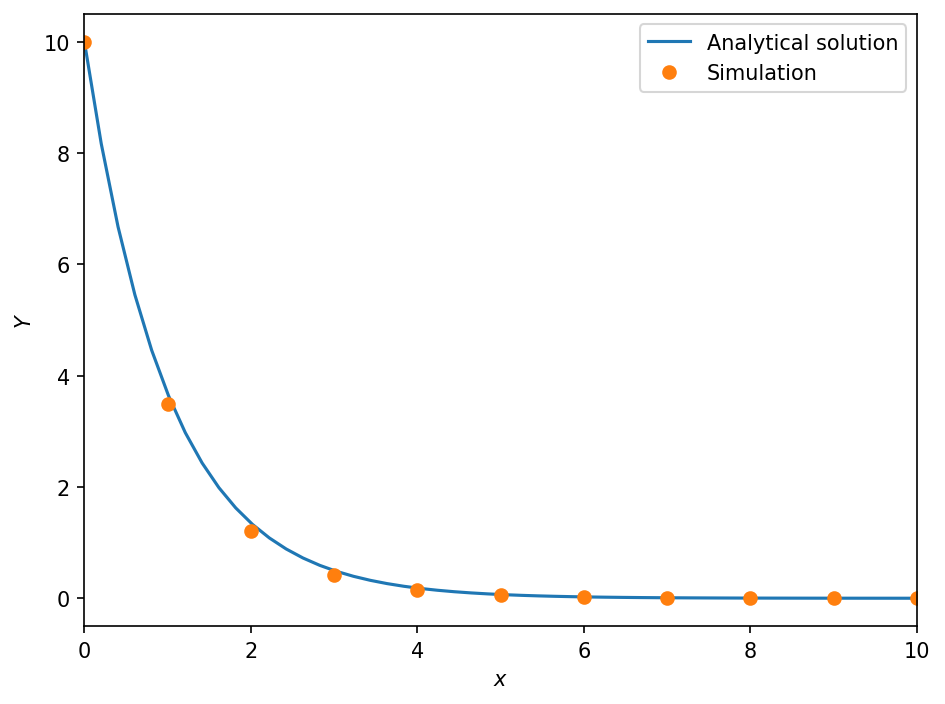

In [47]:
plot(data)

## Reading dump files

Let's say we want to continue the simulation from a dump file that we have stored somewhere. We first have to read the file with `readdump(filename)` which needs the path to the file as argument and which returns a frame object.

In [48]:
from simframe.io import readdump

In [49]:
sim_cont = readdump("1_data/frame.dmp")

In [50]:
sim_cont

Frame (Simple Integration)
--------------------------
    x            : IntVar, Integration variable
    Y            : Field
  -----
    Integrator   : Integrator (Euler 1st-order)
    Writer       : Writer (HDF5 file format using h5py)

We only have to add a few more snapshots.

In [51]:
sim_cont.x.snapshots = np.linspace(1., 20., 20)

Now we can restart the simulation from the current state, read the data, and plot it.

In [52]:
sim_cont.run()

Writing file 1_data/data0011.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0012.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0013.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0014.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0015.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0016.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0017.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0018.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0019.hdf5
Writing dump file 1_data/frame.dmp
Writing file 1_data/data0020.hdf5
Writing dump file 1_data/frame.dmp
Execution time: 0:00:00


In [53]:
data = sim_cont.writer.read.all()

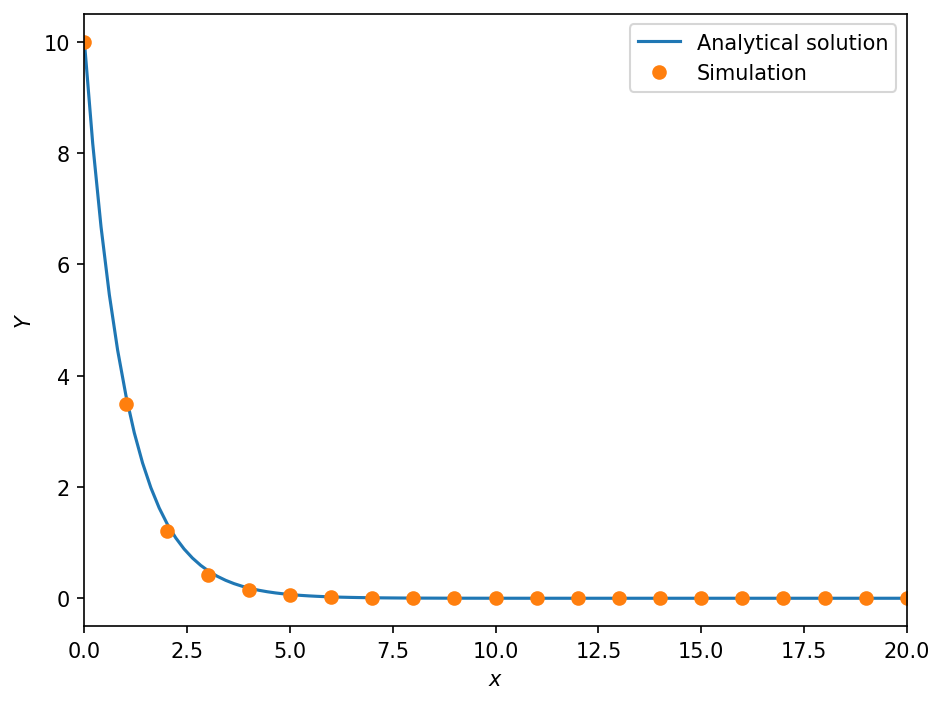

In [54]:
plot(data)

## Progress bar

If you are running `simframe` on an interactive shell if will show by default a progress bar with an estimate of the expected computation time. If you want to turn it off to save some computational overhead you can do so by reducing the verbosity of the frame object.

In [55]:
sim.verbosity = 0